In [1]:
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
from flask_sqlalchemy import SQLAlchemy
import matplotlib.pyplot as plt
import warnings
import os
%matplotlib inline

warnings.filterwarnings("ignore") #, category=DeprecationWarning)

In [2]:
# env variable at tensorflow1.4 per https://conda.io/docs/user-guide/tasks/manage-environments.html#saving-environment-variables
# and https://vsupalov.com/flask-sqlalchemy-postgres/

def get_env_variable(name):
    try:
        return os.environ[name]
    except KeyError:
        message = "Expected environment variable '{}' not set.".format(name)
        raise Exception(message)

# the values of those depend on your setup
POSTGRES_URL = get_env_variable("POSTGRES_URL")
POSTGRES_USER = get_env_variable("POSTGRES_USER")
POSTGRES_PW = get_env_variable("POSTGRES_PW")
POSTGRES_DB = get_env_variable("POSTGRES_DB")

In [3]:
DB_URL = 'postgresql+psycopg2://{user}:{pw}@{url}/{db}'.format(user=POSTGRES_USER,pw=POSTGRES_PW,url=POSTGRES_URL,db=POSTGRES_DB)

# app.config['SQLALCHEMY_DATABASE_URI'] = DB_URL
# app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False # silence the deprecation warning

# db = SQLAlchemy(app)

In [4]:
engine_var = DB_URL
engine = create_engine(engine_var)

In [5]:
# TODO Fix SQL input/output; temp fix:
df = pd.read_pickle('data/kickstarter_data.pkl')

In [6]:
print(df.shape)
df.head()

(19291, 16)


,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,campaign_length,pct_goal_achieved
ID,,,,,,,,,,,,,,,,
1031685482,You Sparkle Inside: A Kids' Book + Commissions...,Children's Books,Publishing,USD,2018-01-02,2000.0,2017-12-06,6083.00,successful,133,US,1054.0,6083.00,2000.0,27 days,304.150000
1176736360,THE NEW BILLY WYLDER RECORD,Indie Rock,Music,USD,2018-01-02,10000.0,2017-11-30,11169.56,successful,177,US,650.0,11169.56,10000.0,33 days,111.695600
1894703097,Driftwood Holly ***The Venice Project***,Indie Rock,Music,EUR,2018-01-02,25000.0,2017-11-28,25417.20,successful,168,DE,0.0,30615.02,30112.5,35 days,101.668809
311863059,On a Limb's debut album,Jazz,Music,USD,2018-01-02,1000.0,2017-12-09,1743.00,successful,39,US,0.0,1743.00,1000.0,24 days,174.300000
2076121120,Briggs Barbecue Sauces,Small Batch,Food,USD,2018-01-02,200000.0,2017-11-03,1.00,failed,1,US,0.0,1.00,200000.0,60 days,0.000500


## KNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split # for #2
from sklearn.model_selection import cross_val_score # for #3


X = pd.get_dummies(df[['main_category','country','currency','usd_goal_real']])
y = pd.get_dummies(df['state'],drop_first=True)

k_range = list(range(1, 101))
# print(y)

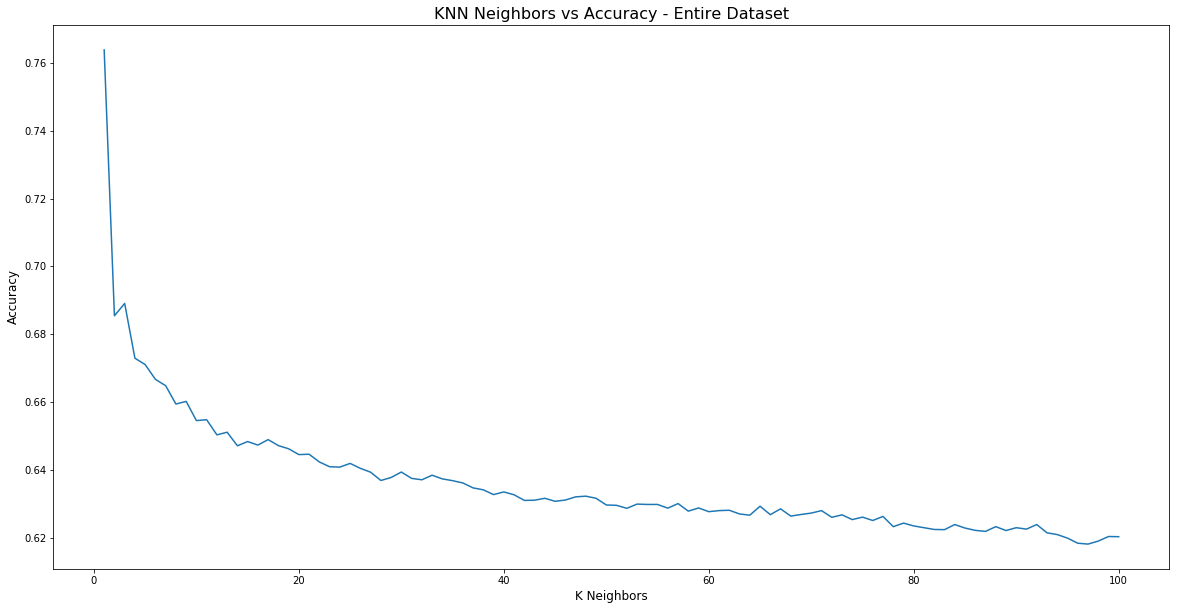

None


In [8]:
# 1. Entire Dataset
k_p1 = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y.values.ravel())
    y_pred = knn.predict(X)
    acc = metrics.accuracy_score(y, y_pred)
    k_p1.append(acc)

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(k_range, k_p1)
plt.title('KNN Neighbors vs Accuracy - Entire Dataset',fontsize=16)
plt.xlabel('K Neighbors', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.savefig('charts/KNN1.png')
print(plt.show()) 

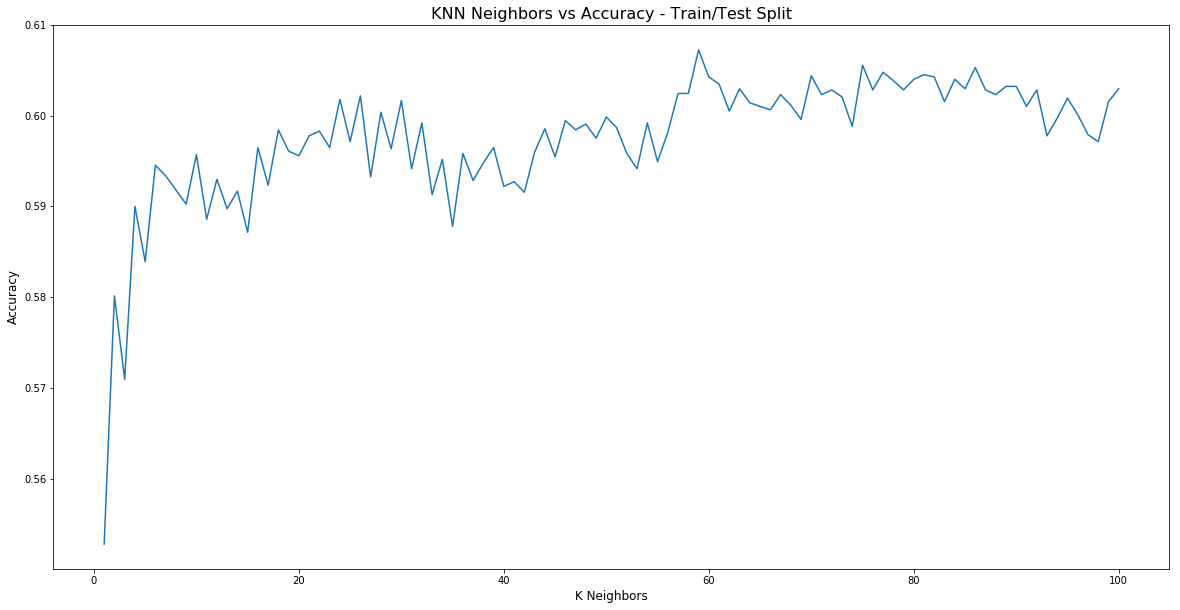

In [9]:
# 2. Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
k_acc = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train.values.ravel())
    y_pred = knn.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    k_acc.append(acc)

    
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(k_range, k_acc)
plt.title('KNN Neighbors vs Accuracy - Train/Test Split',fontsize=16)
plt.xlabel('K Neighbors', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.savefig('charts/KNN2.png')
print(plt.show()) 

None


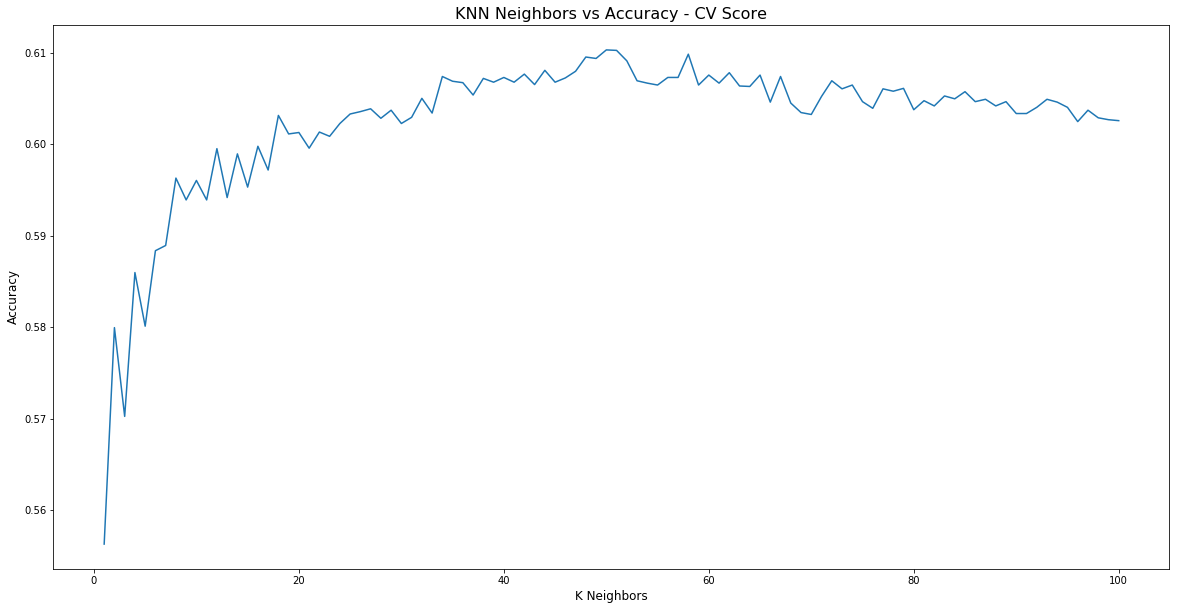

None


In [10]:
# 3. Cross Validation
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
        
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(k_range, k_scores)
plt.title('KNN Neighbors vs Accuracy - CV Score',fontsize=16)
plt.xlabel('K Neighbors', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.savefig('charts/KNN3.png')
print(plt.show()) 

In [11]:
# 10-fold cross-validation with the best KNN model
knn = KNeighborsClassifier(n_neighbors=20)
print(cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean())

0.6012678705676212


In [12]:
# 10-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
print(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

0.5662225928643035


In [13]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y.values.ravel())
grid.grid_scores_

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.55632, std: 0.00998, params: {'n_neighbors': 1},
 mean: 0.57996, std: 0.01179, params: {'n_neighbors': 2},
 mean: 0.57027, std: 0.01183, params: {'n_neighbors': 3},
 mean: 0.58597, std: 0.01036, params: {'n_neighbors': 4},
 mean: 0.58012, std: 0.01539, params: {'n_neighbors': 5},
 mean: 0.58836, std: 0.01460, params: {'n_neighbors': 6},
 mean: 0.58893, std: 0.01513, params: {'n_neighbors': 7},
 mean: 0.59629, std: 0.01640, params: {'n_neighbors': 8},
 mean: 0.59390, std: 0.01700, params: {'n_neighbors': 9},
 mean: 0.59603, std: 0.01562, params: {'n_neighbors': 10},
 mean: 0.59390, std: 0.01706, params: {'n_neighbors': 11},
 mean: 0.59950, std: 0.01423, params: {'n_neighbors': 12},
 mean: 0.59416, std: 0.01640, params: {'n_neighbors': 13},
 mean: 0.59893, std: 0.01426, params: {'n_neighbors': 14},
 mean: 0.59530, std: 0.01663, params: {'n_neighbors': 15},
 mean: 0.59976, std: 0.01404, params: {'n_neighbors': 16},
 mean: 0.59717, std: 0.01534, params: {'n_neighbors': 17},
 mean:

In [14]:
# examine the first tuple
print(grid.grid_scores_[0].parameters)
print(grid.grid_scores_[0].cv_validation_scores)
print(grid.grid_scores_[0].mean_validation_score)

{'n_neighbors': 1}
[0.54300518 0.55440415 0.54611399 0.5624676  0.54536029 0.55106273
 0.57231726 0.56972525 0.55342324 0.5653527 ]
0.5563216007464621


/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [15]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6102845886682909
{'n_neighbors': 50}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weights='uniform')


In [16]:
# Searching multiple parameters simultaneously
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)
grid.grid_scores_

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.55632, std: 0.00998, params: {'weights': 'uniform', 'n_neighbors': 1},
 mean: 0.55632, std: 0.00998, params: {'weights': 'distance', 'n_neighbors': 1},
 mean: 0.57996, std: 0.01179, params: {'weights': 'uniform', 'n_neighbors': 2},
 mean: 0.57369, std: 0.01247, params: {'weights': 'distance', 'n_neighbors': 2},
 mean: 0.57027, std: 0.01183, params: {'weights': 'uniform', 'n_neighbors': 3},
 mean: 0.56705, std: 0.01304, params: {'weights': 'distance', 'n_neighbors': 3},
 mean: 0.58597, std: 0.01036, params: {'weights': 'uniform', 'n_neighbors': 4},
 mean: 0.57861, std: 0.01520, params: {'weights': 'distance', 'n_neighbors': 4},
 mean: 0.58012, std: 0.01539, params: {'weights': 'uniform', 'n_neighbors': 5},
 mean: 0.57566, std: 0.01628, params: {'weights': 'distance', 'n_neighbors': 5},
 mean: 0.58836, std: 0.01460, params: {'weights': 'uniform', 'n_neighbors': 6},
 mean: 0.58266, std: 0.01732, params: {'weights': 'distance', 'n_neighbors': 6},
 mean: 0.58893, std: 0.01513, para

In [17]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6102845886682909
{'weights': 'uniform', 'n_neighbors': 50}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weights='uniform')


In [20]:
# train your model using all data and the best known parameters
# knn = KNeighborsClassifier(n_neighbors=13, weights='uniform')
# knn.fit(X, y)

# make a prediction on out-of-sample data
# knn.predict([[3, 5, 4, 2]])

In [21]:
# shortcut: GridSearchCV automatically refits the best model using all of the data
# grid.predict([[3, 5, 4, 2]])

In [22]:
from sklearn.model_selection import RandomizedSearchCV

# specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(n_neighbors=k_range, weights=weight_options)

In [23]:
# n_iter controls the number of searches
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=42)
rand.fit(X, y)
rand.grid_scores_

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.60132, std: 0.01512, params: {'weights': 'distance', 'n_neighbors': 48},
 mean: 0.58815, std: 0.01791, params: {'weights': 'distance', 'n_neighbors': 8},
 mean: 0.59976, std: 0.01404, params: {'weights': 'uniform', 'n_neighbors': 16},
 mean: 0.60375, std: 0.01261, params: {'weights': 'uniform', 'n_neighbors': 80},
 mean: 0.60754, std: 0.01310, params: {'weights': 'uniform', 'n_neighbors': 65},
 mean: 0.60209, std: 0.01569, params: {'weights': 'distance', 'n_neighbors': 58},
 mean: 0.59800, std: 0.01507, params: {'weights': 'distance', 'n_neighbors': 35},
 mean: 0.60463, std: 0.01178, params: {'weights': 'uniform', 'n_neighbors': 86},
 mean: 0.60417, std: 0.01300, params: {'weights': 'uniform', 'n_neighbors': 88},
 mean: 0.59530, std: 0.01651, params: {'weights': 'distance', 'n_neighbors': 23}]

In [24]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.6075371935099269
{'weights': 'uniform', 'n_neighbors': 65}


In [25]:
# run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
best_scores = []
for _ in range(20):
    rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10)
    rand.fit(X, y)
    best_scores.append(round(rand.best_score_, 3))
print(best_scores)

[0.607, 0.607, 0.607, 0.607, 0.608, 0.606, 0.61, 0.604, 0.609, 0.606, 0.607, 0.606, 0.607, 0.607, 0.608, 0.61, 0.61, 0.607, 0.607, 0.606]
